# Background:
#### Optimization in a simulation loop is slow. If we could speed up the optimization process (require less number of iterations to find the minima), then we could make it practical to use spice based simulations in an optimization loop. 

# Goal
#### Figure out if there are more efficient ways to do optimization.


In [1]:
from hyperopt import fmin, tpe, rand, hp, STATUS_OK, Trials

In [27]:
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize, dummy_minimize
from skopt.plots import plot_objective, plot_convergence, plot_evaluations

In [3]:
import pandas as pd
import numpy as np
import random

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
def simulate_circuit(**kwargs):
    """
    Emulates the spice simulation for now.
    In production, this function will call Midas or Spectre and return the measurements from these design tools
    """
    sim_dc_gain = dc_gain(**kwargs)
    sim_bandwidth = bandwidth(**kwargs)
    return [sim_dc_gain, sim_bandwidth]
    
def dc_gain(**kwargs):
    dc_gain = 100*kwargs['w1']/kwargs['l1'] + 50*kwargs['w2']/kwargs['l2'] 
    return(dc_gain)
    
def bandwidth(**kwargs):
    bandwidth = (100*kwargs['l1']/kwargs['w1'] + 50*kwargs['l1']/kwargs['w1'])*1e5
    return(bandwidth)
    

In [94]:
def optimize_hyperopt(num_points = 1, max_evals = 25, verbose=False, algo=tpe.suggest, plot_sample_hist=False, seed=101):
    
    def loss(params):
        (sim_dc_gain, sim_bandwidth) = simulate_circuit(**params)
        loss = abs(target_dc_gain - sim_dc_gain)/target_dc_gain + abs(target_bandwidth - sim_bandwidth)/target_bandwidth + params['w1']*params['l1']/500 + params['w2']*params['l2']/100
        # print (params)
        # print("  --> Sim DC Gain: {} | Sim Bandwidth: {} >> Loss: {}".format(sim_dc_gain, sim_bandwidth, loss))
        return (loss)   


    space = {'w1': hp.uniform('w1', 1, 50),
             'l1': hp.uniform('l1', 1, 10),
             'w2': hp.uniform('w2', 1, 10),
             'l2': hp.uniform('l2', 1, 10)}
    
    target_dc_gain_list = []
    target_bw_list = []

    optimizer_dc_gain_list = []
    optimizer_bw_list = []

    np.random.seed(seed)
    w1_list = np.random.randint(1,50,num_points) 
    l1_list = np.random.randint(1,10,num_points) 
    w2_list = np.random.randint(1,10,num_points) 
    l2_list = np.random.randint(1,10,num_points) 
        
    for w1, l1, w2, l2 in zip(w1_list,l1_list,w2_list,l2_list): 
        kwargs = {"w1":w1, "l1":l1, "w2":w2, "l2":l2}  # Target Geometries
        (sim_dc_gain, sim_bandwidth) = simulate_circuit(**kwargs) # Target Output Values
        if (verbose):
            print("w1: {}, l1: {}, w2:{}, l2: {}: Target DC Gain: {}, Target Bandwidth: {}".format(w1,l1,w2,l2,sim_dc_gain, sim_bandwidth))

        target_dc_gain = sim_dc_gain
        target_bandwidth = sim_bandwidth

        tpe_trials = Trials()
        best = fmin(loss,
                space=space,
                algo=algo,
                rstate=np.random.RandomState(seed=seed),
                trials=tpe_trials,
                max_evals=max_evals             
               )
        
        if (plot_sample_hist):
            plot_hist(tpe_trials)
      
        (optimizer_dc_gain, optimizer_bandwidth) = simulate_circuit(**best)

        target_dc_gain_list.append(target_dc_gain)
        target_bw_list.append(target_bandwidth)

        optimizer_dc_gain_list.append(optimizer_dc_gain)
        optimizer_bw_list.append(optimizer_bandwidth)

        if (verbose):
            print ("  --> Best Geometries from Optimizer: {}".format(best))
            print ("  --> Output with Best Geometries >> DC Gain: {}, Bandwidth: {}".format(optimizer_dc_gain, optimizer_bandwidth))
            print (" ") 

    return (tpe_trials, target_dc_gain_list, target_bw_list, optimizer_dc_gain_list, optimizer_bw_list)
    

def plot_results(target_dc_gain_list, target_bw_list, optimizer_dc_gain_list, optimizer_bw_list):
    fig, axes = plt.subplots(1,2,figsize = (10,4))

    axes[0].scatter(target_dc_gain_list,optimizer_dc_gain_list)
    axes[0].set_xlabel('Target DC Gain')
    axes[0].set_ylabel('DC Gain with Optimizer Recommended Values')

    axes[1].scatter(target_bw_list,optimizer_bw_list)
    axes[1].set_xlabel('Target Bandwidth')
    axes[1].set_ylabel('Bandwidth with Optimizer Recommended Values')

    plt.tight_layout()
    
def plot_hist(tpe_trials):
    tpe_results = pd.DataFrame({'Loss': [x['loss'] for x in tpe_trials.results], 
                            'Iteration': tpe_trials.idxs_vals[0]['l1'],
                            'w1': tpe_trials.idxs_vals[1]['w1'],
                            'l1': tpe_trials.idxs_vals[1]['l1'],
                            'w2': tpe_trials.idxs_vals[1]['w2'],
                            'l2': tpe_trials.idxs_vals[1]['l2']
                           })
    geoms = ['w1','l1','w2','l2']
    tpe_results[geoms].hist(figsize=(10,8))

def plot_loss_by_iter(trials, ax):
    results = pd.DataFrame({'Loss': [x['loss'] for x in trials.results], 
                            'Iteration': trials.idxs_vals[0]['l1'],
                            'w1': trials.idxs_vals[1]['w1'],
                            'l1': trials.idxs_vals[1]['l1'],
                            'w2': trials.idxs_vals[1]['w2'],
                            'l2': trials.idxs_vals[1]['l2']
                           })
    
    #fig, axes = plt.subplots(1,1,figsize = (5,4))

    ax.scatter(results['Iteration'],results['Loss'])
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    
    return ax
    
def plot_loss_by_iter_compare(trials1, trials2, figsize=(10,6)):
    # # If using other function
    # fig, axes = plt.subplots(1,2,figsize = (10,4))
    # axes[0] = plot_loss_by_iter(trials1, axes[0])
    # axes[1] = plot_loss_by_iter(trials2, axes[1])
       
     
    results1 = pd.DataFrame({'Loss': [x['loss'] for x in trials1.results], 
                            'Iteration': trials1.idxs_vals[0]['l1']})
    results2 = pd.DataFrame({'Loss': [x['loss'] for x in trials2.results], 
                            'Iteration': trials2.idxs_vals[0]['l1']})
    
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)

    ax1.scatter(results1['Iteration'],results1['Loss'], s=10, c='r', marker="s", label='first')
    ax1.scatter(results2['Iteration'],results2['Loss'], s=10, c='b', marker="o", label='second')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    plt.legend(loc="best", prop={'size': 14}, numpoints=1);
    
def compute_min_loss_by_iter(trails):
    results = pd.DataFrame({'Loss': [x['loss'] for x in trails.results], 
                            'Iteration': trails.idxs_vals[0]['l1']})

    global min_loss;
    min_loss = 1e6

    def rolling_min(row):
        global min_loss
        if (row['Loss'] < min_loss):
            min_loss = row['Loss']
        return(min_loss)

    results['Min Loss'] = results.apply(rolling_min, axis=1)
    return(results)
    
def plot_min_loss_by_iter_compare(trials1, trials2, figsize=(10,6)):
    results1 = compute_min_loss_by_iter(trials1)
    results2 = compute_min_loss_by_iter(trials2)
    
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)

    ax1.scatter(results1['Iteration'],results1['Min Loss'], s=10, c='r', marker="s", label='first')
    ax1.scatter(results2['Iteration'],results2['Min Loss'], s=10, c='b', marker="o", label='second')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Min Loss')
    plt.legend(loc="best", prop={'size': 14}, numpoints=1);
    
    min_loss1 = results1['Min Loss'].iloc[-1]
    min_loss2 = results2['Min Loss'].iloc[-1]
    min_loss_loc1 = results1.index[results1['Loss'] == min_loss1].tolist()[0] + 1
    min_loss_loc2 = results2.index[results2['Loss'] == min_loss2].tolist()[0] + 1
                                    
    
    print ("Trial 1 Min Loss: {} occuring at iteration: {}".format(min_loss1, min_loss_loc1))
    print ("Trial 2 Min Loss: {} occuring at iteration: {}".format(min_loss1, min_loss_loc2))
    

In [95]:
# https://scikit-optimize.github.io/notebooks/strategy-comparison.html

def optimize_skopt(num_points=1, n_calls=25, n_random_starts=5, minimizer=gp_minimize, base_estimator=None, acq_func="EI", n_jobs=1, verbose=False, optimizer_verbose=False, seed=101):
    
    space = [Real(1, 50, name='w1'),
             Real(1, 10, name='l1'),
             Real(1, 10, name='w2'),
             Real(1, 10, name='l2')]
    
    @use_named_args(space)
    def loss(**params):
        (sim_dc_gain, sim_bandwidth) = simulate_circuit(**params)
        loss = abs(target_dc_gain - sim_dc_gain)/target_dc_gain + abs(target_bandwidth - sim_bandwidth)/target_bandwidth + params['w1']*params['l1']/500 + params['w2']*params['l2']/100
        # print (params)
        # print("  --> Sim DC Gain: {} | Sim Bandwidth: {} >> Loss: {}".format(sim_dc_gain, sim_bandwidth, loss))
        return (loss)   
    
    target_dc_gain_list = []
    target_bw_list = []

    optimizer_dc_gain_list = []
    optimizer_bw_list = []

    np.random.seed(seed)
    w1_list = np.random.randint(1,50,num_points) 
    l1_list = np.random.randint(1,10,num_points) 
    w2_list = np.random.randint(1,10,num_points) 
    l2_list = np.random.randint(1,10,num_points) 
        
    for w1, l1, w2, l2 in zip(w1_list,l1_list,w2_list,l2_list): 
        kwargs = {"w1":w1, "l1":l1, "w2":w2, "l2":l2}  # Target Geometries
        (sim_dc_gain, sim_bandwidth) = simulate_circuit(**kwargs) # Target Output Values
        if (verbose):
            print("w1: {}, l1: {}, w2:{}, l2: {}: Target DC Gain: {}, Target Bandwidth: {}".format(w1,l1,w2,l2,sim_dc_gain, sim_bandwidth))

        target_dc_gain = sim_dc_gain
        target_bandwidth = sim_bandwidth

        res = minimizer(loss,                # the function to minimize
                        space,               # the bounds on each dimension of x
                        acq_func=acq_func,   # the acquisition function
                        n_calls=n_calls,     # the number of evaluations of f 
                        n_random_starts=n_random_starts,   # the number of random initialization points
                        base_estimator=base_estimator,
                        verbose=optimizer_verbose,
                        n_jobs=n_jobs,
                        random_state=seed)   # the random seed
        
      
        (optimizer_dc_gain, optimizer_bandwidth) = simulate_circuit(w1=res.x[0], l1=res.x[1], w2=res.x[2], l2=res.x[3])

        target_dc_gain_list.append(target_dc_gain)
        target_bw_list.append(target_bandwidth)

        optimizer_dc_gain_list.append(optimizer_dc_gain)
        optimizer_bw_list.append(optimizer_bandwidth)

        if (verbose):
            print ("  --> Best Geometries from Optimizer: {}".format(res.x))
            print ("  --> Output with Best Geometries >> DC Gain: {}, Bandwidth: {}".format(optimizer_dc_gain, optimizer_bandwidth))
            print (" ") 

    return (res, target_dc_gain_list, target_bw_list, optimizer_dc_gain_list, optimizer_bw_list)


In [96]:
num_points = 1 # Number of points to evaluate
seed=4101 # determines which ramdom point(s) you pick for evaluation (Change to evaluate a different target value)

### Using Hyperopt 

In [97]:
max_evals=500

In [98]:
%%time
# Part 1: Random Search ----
rand_trials, target_dc_gain_list, target_bw_list, optimizer_dc_gain_list, optimizer_bw_list  = optimize_hyperopt(num_points=num_points, max_evals=max_evals, verbose=True, algo=rand.suggest, plot_sample_hist=False, seed=seed)

w1: 24, l1: 7, w2:4, l2: 1: Target DC Gain: 542.8571428571429, Target Bandwidth: 4375000.0
100%|██████████| 500/500 [00:00<00:00, 762.20it/s, best loss: 0.4819639116275484]
  --> Best Geometries from Optimizer: {'l1': 4.733791180816139, 'l2': 2.035784338736751, 'w1': 19.931412121201156, 'w2': 4.694690287877414}
  --> Output with Best Geometries >> DC Gain: 536.3496592065138, Bandwidth: 3562560.8100648164
 
Wall time: 673 ms


In [99]:
%%time
# Part 2: TPE Search ----
tpe_trials, target_dc_gain_list, target_bw_list, optimizer_dc_gain_list, optimizer_bw_list  = optimize_hyperopt(num_points=num_points, max_evals=max_evals, verbose=True, algo=tpe.suggest, plot_sample_hist=False, seed=seed)

w1: 24, l1: 7, w2:4, l2: 1: Target DC Gain: 542.8571428571429, Target Bandwidth: 4375000.0
100%|██████████| 500/500 [00:07<00:00, 43.92it/s, best loss: 0.1646113131514854] 
  --> Best Geometries from Optimizer: {'l1': 2.5040432306921705, 'l2': 1.0055155036921617, 'w1': 7.9549899676898495, 'w2': 4.528326349148736}
  --> Output with Best Geometries >> DC Gain: 542.8601753066475, Bandwidth: 4721646.238768327
 
Wall time: 7.39 s


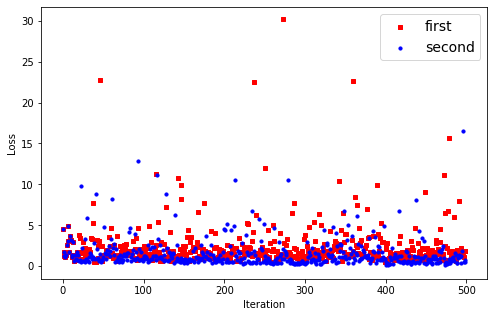

In [100]:
plot_loss_by_iter_compare(rand_trials,tpe_trials, figsize=(8,5))

Trial 1 Min Loss: 0.4819639116275484 occuring at iteration: 259
Trial 2 Min Loss: 0.4819639116275484 occuring at iteration: 404


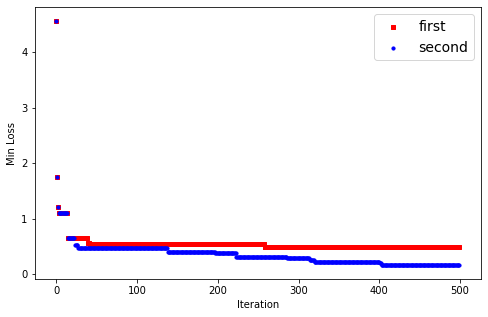

In [101]:
plot_min_loss_by_iter_compare(rand_trials,tpe_trials, figsize=(8,5))

#### Takes more than 100 iterations to get to minima !!!

In [14]:
if (num_points > 1):
    plot_results(target_dc_gain_list, target_bw_list, optimizer_dc_gain_list, optimizer_bw_list)

### Using Skopt (allows for Gaussian Process Based Optimization) 

In [30]:
# For skopt
n_calls=50
n_random_starts=10
n_jobs=-1
verbose=True
optimizer_verbose=False

In [31]:
%%time
res_gp_EI, target_dc_gain_list, target_bw_list, optimizer_dc_gain_list, optimizer_bw_list  = optimize_skopt(num_points=num_points,
                                                                                                            n_calls=n_calls, n_random_starts=n_random_starts,
                                                                                                            minimizer=gp_minimize, base_estimator=None, acq_func="EI",
                                                                                                            n_jobs=n_jobs, verbose=verbose, optimizer_verbose=optimizer_verbose, seed=seed)

w1: 24, l1: 7, w2:4, l2: 1: Target DC Gain: 542.8571428571429, Target Bandwidth: 4375000.0
  --> Best Geometries from Optimizer: [12.948530825804848, 3.9896327753943277, 4.643448227943068, 1.0]
  --> Output with Best Geometries >> DC Gain: 556.7268642696998, Bandwidth: 4621720.597957887
 
Wall time: 29.3 s


In [32]:
%%time
res_gp_PI, target_dc_gain_list, target_bw_list, optimizer_dc_gain_list, optimizer_bw_list  = optimize_skopt(num_points=num_points,
                                                                                                            n_calls=n_calls, n_random_starts=n_random_starts,
                                                                                                            minimizer=gp_minimize, base_estimator=None, acq_func="PI",
                                                                                                            n_jobs=n_jobs, verbose=verbose, optimizer_verbose=optimizer_verbose, seed=seed)

w1: 24, l1: 7, w2:4, l2: 1: Target DC Gain: 542.8571428571429, Target Bandwidth: 4375000.0
  --> Best Geometries from Optimizer: [6.523553669732394, 1.820695139915371, 4.106017259766695, 1.0]
  --> Output with Best Geometries >> DC Gain: 563.6010268496839, Bandwidth: 4186434.0329480087
 
Wall time: 19.6 s


In [33]:
%%time
res_gp_LCB, target_dc_gain_list, target_bw_list, optimizer_dc_gain_list, optimizer_bw_list  = optimize_skopt(num_points=num_points,
                                                                                                             n_calls=n_calls, n_random_starts=n_random_starts,
                                                                                                             minimizer=gp_minimize, base_estimator=None, acq_func="LCB",
                                                                                                             n_jobs=n_jobs, verbose=verbose, optimizer_verbose=optimizer_verbose, seed=seed)

w1: 24, l1: 7, w2:4, l2: 1: Target DC Gain: 542.8571428571429, Target Bandwidth: 4375000.0
  --> Best Geometries from Optimizer: [8.767610517255505, 2.396148176854228, 3.9990734061151163, 1.1189752805351378]
  --> Output with Best Geometries >> DC Gain: 544.5979089374367, Bandwidth: 4099431.946945596
 
Wall time: 24.1 s


In [34]:
%%time
res_gp_hedge, target_dc_gain_list, target_bw_list, optimizer_dc_gain_list, optimizer_bw_list  = optimize_skopt(num_points=num_points,
                                                                                                                   n_calls=n_calls, n_random_starts=n_random_starts,
                                                                                                                   minimizer=forest_minimize, base_estimator='ET', acq_func="gp_hedge",
                                                                                                                   n_jobs=n_jobs, verbose=verbose, optimizer_verbose=optimizer_verbose, seed=seed)

w1: 24, l1: 7, w2:4, l2: 1: Target DC Gain: 542.8571428571429, Target Bandwidth: 4375000.0
  --> Best Geometries from Optimizer: [8.494327589992892, 2.4541842028501244, 6.0340348619731055, 1.4563584452447487]
  --> Output with Best Geometries >> DC Gain: 553.2778738622274, Bandwidth: 4333805.431064458
 
Wall time: 23.5 s


In [35]:
%%time
res_forest_ET, target_dc_gain_list, target_bw_list, optimizer_dc_gain_list, optimizer_bw_list  = optimize_skopt(num_points=num_points,
                                                                                                                n_calls=n_calls, n_random_starts=n_random_starts,
                                                                                                                minimizer=forest_minimize, base_estimator='ET', acq_func="LCB",
                                                                                                                n_jobs=n_jobs, verbose=verbose, optimizer_verbose=optimizer_verbose, seed=seed)

w1: 24, l1: 7, w2:4, l2: 1: Target DC Gain: 542.8571428571429, Target Bandwidth: 4375000.0
  --> Best Geometries from Optimizer: [8.884447786822932, 2.646973339784127, 7.5212854194807495, 1.3588428662258325]
  --> Output with Best Geometries >> DC Gain: 612.3988508001603, Bandwidth: 4469000.33062834
 
Wall time: 11.4 s


In [36]:
%%time
res_forest_RF, target_dc_gain_list, target_bw_list, optimizer_dc_gain_list, optimizer_bw_list  = optimize_skopt(num_points=num_points,
                                                                                                                n_calls=n_calls, n_random_starts=n_random_starts,
                                                                                                                minimizer=forest_minimize, base_estimator='RF', acq_func="LCB",
                                                                                                                n_jobs=n_jobs, verbose=verbose, optimizer_verbose=optimizer_verbose, seed=seed)

w1: 24, l1: 7, w2:4, l2: 1: Target DC Gain: 542.8571428571429, Target Bandwidth: 4375000.0
  --> Best Geometries from Optimizer: [8.958082356089992, 2.63369724355133, 3.6685420391710775, 1.1938378596702106]
  --> Output with Best Geometries >> DC Gain: 493.7782411759107, Bandwidth: 4410035.215451315
 
Wall time: 10.5 s


In [37]:
# %%time
# res_dummy, target_dc_gain_list, target_bw_list, optimizer_dc_gain_list, optimizer_bw_list  = optimize_skopt(num_points=num_points,
#                                                                                                             n_calls=n_calls, n_random_starts=n_random_starts,
#                                                                                                             minimizer=dummy_minimize, base_estimator=None, acq_func=None,
#                                                                                                             n_jobs=n_jobs, verbose=verbose, optimizer_verbose=optmize_verbose, seed=seed)

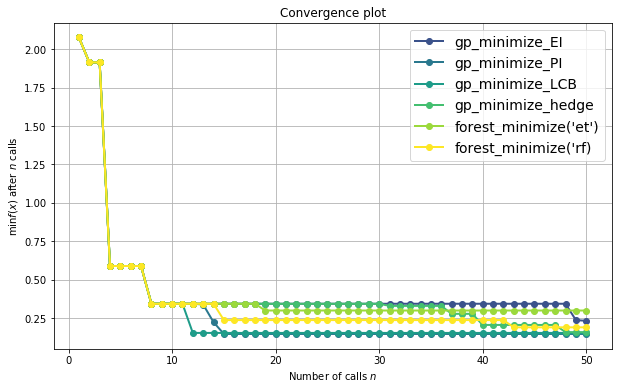

In [38]:
plt.figure(figsize=(10,6))
plot = plot_convergence(("gp_minimize_EI", res_gp_EI),
                        ("gp_minimize_PI", res_gp_PI),
                        ("gp_minimize_LCB", res_gp_LCB),
                        ("gp_minimize_hedge", res_gp_hedge),
                        ("forest_minimize('et')", res_forest_ET),
                        ("forest_minimize('rf)", res_forest_RF)
                        # ("dummy_minimize", res_dummy)
                       )

plot.legend(loc="best", prop={'size': 14}, numpoints=1);

In [47]:
d = {'Loss': [res_gp_EI.fun, res_gp_PI.fun, res_gp_LCB.fun, res_gp_hedge.fun, res_forest_ET.fun, res_forest_RF.fun]}
index = ["gp_minimize_EI", "gp_minimize_PI", "gp_minimize_LCB", "gp_minimize_hedge", "forest_minimize('et')", "forest_minimize('rf)"]
pd.DataFrame(data=d, index=index)

,Loss
gp_minimize_EI,0.231697
gp_minimize_PI,0.146128
gp_minimize_LCB,0.152959
gp_minimize_hedge,0.158182
forest_minimize('et'),0.298825
forest_minimize('rf),0.189399


### Conclusion

1. TPE search reaches the minima faster than random search. This can be seen from the Min Loss Plot
2. At least for this function, it still takes over 150 iterations to get to the minima which may be still too long since we have to wait for the the simulation results after every iteration and each simulation result could be the output of a statitcal run. 
3. Forest_minimize also not able to converge to the right global minima (may be getting stuck in local minima)
4. **GP based Bayesian Optimization offers a much better solution where the output is able to converge to the minimum in 15-20 iterations**. This could offer a practical option for "Optimization in a Simulation loop"

### References

1. SKOPT for GP Optimization (https://scikit-optimize.github.io/notebooks/bayesian-optimization.html)